In [ ]:
import os
import tensorflow as tf

# Check TensorFlow version and available devices
print(tf.__version__)
print(tf.config.list_physical_devices())

In [2]:
# Set input and target directories
input_dir = './images'
target_dir = './annotations/trimaps'

# Load image paths and target paths
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')])

In [3]:
# Display sample input and target paths
print(input_img_paths[0]) 
print(target_paths[0]) 

./images/Abyssinian_1.jpg
./annotations/trimaps/Abyssinian_1.png


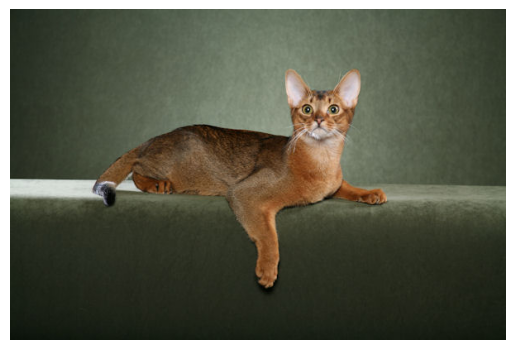

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Visualize sample input and target images
plt.axis('off')
plt.imshow(load_img(input_img_paths[0]))

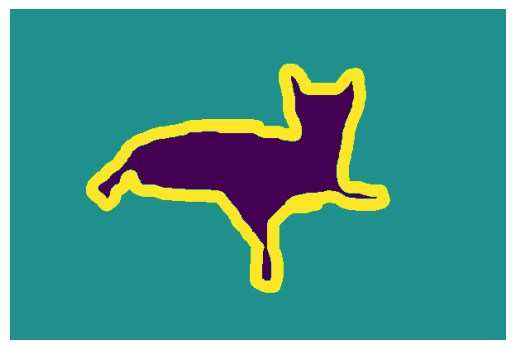

In [5]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])
    
img = img_to_array(load_img(target_paths[0], color_mode='grayscale'))
display_target(img)

In [6]:
import numpy as np
import random

# Data preprocessing
img_size = (200, 200)
num_imgs = len(input_img_paths)

# Shuffle image and target paths
random.Random(0).shuffle(input_img_paths)
random.Random(0).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target_image(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img

In [7]:
input_imgs = np.zeros((num_imgs, ) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs, ) + img_size + (1,), dtype='uint8')

# Load images and targets into arrays
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target_image(target_paths[i])
    
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Build the segmentation model using Keras
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    
    outputs = layers.Conv2D(num_classes, 3, padding='same', activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Set up callbacks for model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
]

# Train the model
history = model.fit(train_input_imgs, train_targets, 
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets)
                    )

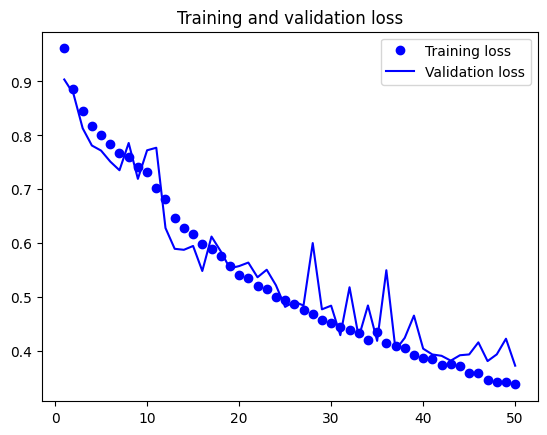

In [10]:
# Plot training and validation loss
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

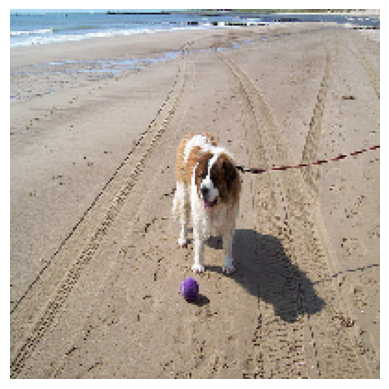

In [11]:
from tensorflow.keras.utils import array_to_img

# Load the saved model with best weights
model = keras.models.load_model('oxford_segmentation.keras')

# Display a sample test image and its predicted mask
i = 10
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

1/1 [==============================] - 1s 601ms/step


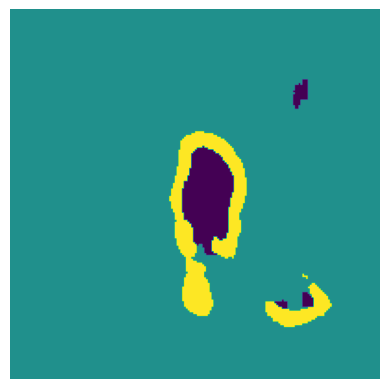

In [12]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)
    
display_mask(mask)